# **Задание на лабораторную работу.**

Разработать собственную программу на языке Python для кластеризации данных алгоритмом К-средних. Использовать набор данных, соответствующий Вашему варианту (название файла с данными Y.csv, где Y – номер варианта). Необходимо найти оптимальное число кластеров, используя приведённые критерии и метрики расстояния. Провести сравнение различных комбинаций критериев и метрик расстояния. Номер варианта указан в задании к лабораторной работе №1.

**Результаты, которые необходимо получить в итоге:**

1. Графики зависимости значений обоих критериев от числа кластеров и метрики расстояния.
2. Оптимальное количество кластеров.
3. Выводы о влиянии метрики расстояния на оптимальное количество кластеров.

**Нотбук:**

Используйте предоставленные данные и сгруппируйте их с помощью K-Means и его мягкой версии, сравните результаты. Найдите количество кластеров, которое дает наивысшую чистоту, используйте различные метрики расстояния: евклидово расстояние, манхэттенское расстояние, расстояние Чебышева. Постройте графики чистоты и значений DBI в зависимости от K для каждой из метрик расстояния.

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style(style="darkgrid")
sns.set_palette(palette=sns.color_palette("coolwarm"))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

import warnings
warnings.simplefilter(action='ignore')

# **Процесс выполнения**

Во-первых, так как в данных нет лейблов, то будет исследован только индекс Дэвиса–Болдина. Относительно его значения и будет выбираться отимальное количество кластеров, так как это один из способов + вычисления довольно трудозатратны и по времени, и по RAM. 

$DBS = 1/n * \sum_{i=1}^{n} max_{i{\not=}j} ((σ_i + σ_j)/(d(c_i,c_j)$

где $σ_i$ - среднее расстояние всех точек кластера $i$ от центра кластера $c_i$, $n$ - количество кластеров.

DBS учитывает как разделение, так и компактность кластеров. Это связано с тем, что оператор $max$ меры многократно выбирает значения, средняя точка которых наиболее удалена от его центра, и где центры находятся ближе всего друг к другу.Когда индекс DB падает, кластеризация улучшается.

Для k-means была выбрана библиотека pyclustering, так как она работает довольно быстро, но из-за нехватки RAM перебор количества кластеров в цикле не удаётся, поэтому процесс выполнения для каждого k запускался отдельно и далее был собран массив из всех значений DBI.  Были построены двумерные графики центров полученных кластеров для каждой пары признаков.

Для soft k-means была использована собственная реализация. Здесь не возникло проблем с RAM, но возникли проблемы с временем выполнения. Цикл для подбора количества кластеров (10 итераций) выполняется за ~5 часов. Для soft kmeans также были реализованы метрики Чебышева, Манхэттена и Евклидова. 



# Предварительная обработка данных

In [2]:
# функция для создания датафрейма

def create_df(data):
  X,Y,Z, value = [],[],[],[]

  for z in range(data.shape[0]):
    for y in range(data.shape[1]):
      for x in range(data.shape[2]):
        X.append(x)
        Y.append(y)
        Z.append(z)
        value.append(data[z][y][x])

  return pd.DataFrame({'X': X, 'Y': Y, 'Z': Z, 'Value': value})

In [3]:
# создание датафрема из 3х мерного массива

npy_data = np.load("45.npy")
print("Original data shape: ", npy_data.shape, "\n")
data = create_df(npy_data)
print("Data shape: ", data.shape, "\n")
data.head()

Original data shape:  (83, 170, 510) 

Data shape:  (7196100, 4) 



,X,Y,Z,Value
0,0,0,0,17
1,1,0,0,17
2,2,0,0,17
3,3,0,0,18
4,4,0,0,18


In [43]:
print("mean of value column: ", data.Value.mean())

mean of value column:  38.82070663275941


# K-Means

Использутеся реализация алгоритма `k-means` из библиотеки `pyclustering`, т.к. там есть возможность выбора метрик.

Для расчёта индекса Дэвиса–Болдина использовалась реализация из `sklearn`, для этого предобрабатывается результат кластеризации (приводится к одномерному массиву), функция `create_kmeans_result`.

Оптимальное число кластеров выбирается также исходя из значения индекса Дэвиса–Болдина, чем меньше значение - тем лучше.


In [ ]:
! pip install pyclustering

In [12]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [4]:
from sklearn.metrics import davies_bouldin_score

In [5]:
euc_metric = distance_metric(type_metric.EUCLIDEAN)
man_metric = distance_metric(type_metric.MANHATTAN)
cheb_metric = distance_metric(type_metric.CHEBYSHEV)

In [46]:
def create_kmeans_result(clusters):

  clusters_res = np.zeros(data.shape[0])
  for cluster_num, cluster in enumerate(clusters):
    for element_index in cluster:
      clusters_res[element_index] = cluster_num

  return clusters_res

Из-за размера входных данных не хватает RAM, поэтому подбор оптимального количества кластеров в цикле сделать не выйдет, RAM заканчивается после 2х итераций. Для каждого k результат будет посчитан и вручную записан в массив.

## Евклидово расстояние

In [14]:
%%time
k = 3
initial_centers = kmeans_plusplus_initializer(data.to_numpy(), k).initialize()
kmeans_instance = kmeans(data.to_numpy(), initial_centers, metric=euc_metric)

kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

clusters_res = create_kmeans_result(clusters)
score_kemans_d = davies_bouldin_score(data, clusters_res)
print("k = ", k, " DBI = ", score_kemans_d )
print("centers: \n", final_centers)

k =  3  DBI =  0.9297693913668207
centers: 
 [[424.66873589494855, 84.44852371653954, 41.029635125661855, 31.16677278093753], [84.58392015137386, 84.62410852735779, 40.98608630025786, 45.42451153567578], [254.7644620407735, 84.42722852404174, 40.98437233891496, 39.847330701379256]]
CPU times: user 2min 14s, sys: 6.1 s, total: 2min 21s
Wall time: 2min 20s


In [32]:
# [3, 13]
dbs_euc = [0.9297693518956472, 1.1577462492337616,
       1.2048871292062238, 1.3625765570483839, 1.1654589793926764,
       1.1407750893327915, 1.1407750893327915, 1.0938756260058442,
       1.058364480232167, 1.018895139255773, 0.9794934634003603]

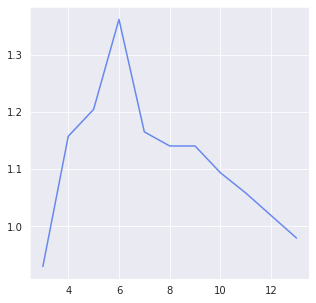

In [48]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_euc)

Видим, что самое минимальное значение индекса достигается в точке k = 3, которая и является стартовой для алгоритма. Дальше индекс растёт и достигает максимума при k=6, далее резко падает, выравнивается и снова начинает падать, но более плавно, начиная с k=9.

Оптимальное количество кластеров на отрезке [3,13] - 3.

Визуализируем центры кластеров:

In [23]:
centers_data = pd.DataFrame({'0': final_centers[0], '1': final_centers[1], '2': final_centers[2], 
                             'index': ['X', 'Y', 'Z', 'Value']})
centers_data = centers_data.set_index('index')
centers_data = centers_data.T
centers_data['name'] = ['first cluster',	'second cluster',	'third cluster']
centers_data

index,X,Y,Z,Value,name
0,424.668736,84.448524,41.029635,31.166773,first cluster
1,84.583920,84.624109,40.986086,45.424512,second cluster
2,254.764462,84.427229,40.984372,39.847331,third cluster


Видно, что центры кластеров по признакам X, Z примерно одинаковы. Самая большая разница в центрах кластеров для X, а для Value центры сконцентрированы близ среднего значения (38).

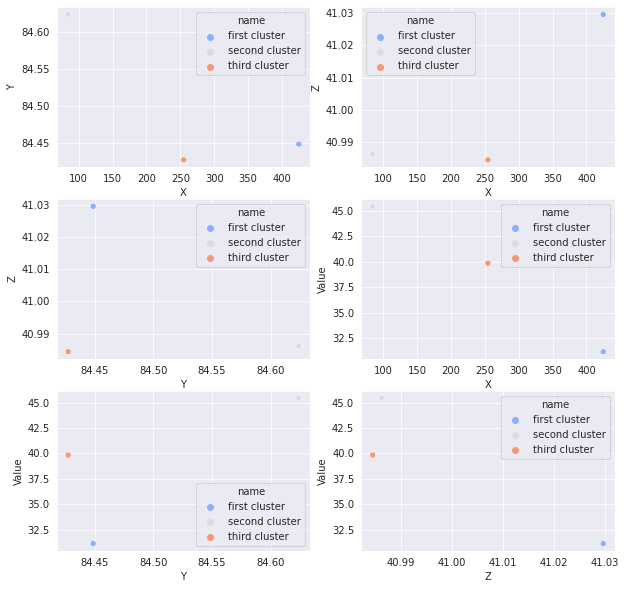

In [51]:
sns.set_palette(palette=sns.color_palette("coolwarm", 3))

f, axes = plt.subplots(3, 2, figsize=(10,10))

sns.scatterplot(centers_data.X, centers_data.Y,  hue=centers_data.name, ax=axes[0,0])
sns.scatterplot(centers_data.X, centers_data.Z,  hue=centers_data.name, ax=axes[0,1])
sns.scatterplot(centers_data.Y, centers_data.Z,  hue=centers_data.name, ax=axes[1,0])
sns.scatterplot(centers_data.X, centers_data.Value,  hue=centers_data.name, ax=axes[1,1])
sns.scatterplot(centers_data.Y, centers_data.Value,  hue=centers_data.name, ax=axes[2,0])
sns.scatterplot(centers_data.Z, centers_data.Value,  hue=centers_data.name, ax=axes[2,1])

## Манхэттенское расстояние

In [7]:
%%time
k = 12
initial_centers = kmeans_plusplus_initializer(data.to_numpy(), k).initialize()
kmeans_instance = kmeans(data.to_numpy(), initial_centers, metric=man_metric)

kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

clusters_res = create_kmeans_result(clusters)
score_kemans_d = davies_bouldin_score(data, clusters_res)
print("k = ", k, " DBI = ", score_kemans_d )
print("centers: \n", final_centers)

k =  12  DBI =  1.0369261515792871
centers: 
 [[83.52338361933384, 96.33047482614393, 39.1889939983931, 111.07643555956581], [315.3654081483727, 139.56176555024692, 42.19716893527139, 26.65762432418995], [149.12625274457554, 39.462331031748555, 41.18377723201518, 19.06542947027233], [448.5526148312927, 137.52505210978964, 41.82391124111798, 15.208833266189066], [49.53223383483075, 36.933819390161126, 41.22220292148783, 21.048168199466655], [458.61450239170404, 32.41338262333655, 41.6499182805092, 16.654254344870342], [352.0950728439205, 35.53562259972461, 41.292755815307835, 17.652654722529363], [186.399851699929, 134.90084562593674, 43.03768083931529, 40.19829454918356], [425.09427009192865, 87.22812442390183, 39.281147311985315, 75.92111279835946], [61.15307126625991, 143.06526328973501, 41.51306876129471, 32.497239170498666], [249.43334728471277, 39.86152558334205, 41.271352337105185, 19.260181766543596], [274.004091282586, 97.60501208934315, 36.77159830341569, 102.6345521364991]]
C

In [8]:
dbs_man = [ 1.3963511007341178, 1.1950117819471928, 1.3173326127589362,
            1.3052772527585241, 1.3418932940413686, 1.1688618792135625, 
            1.1217306047074884,  1.0495214165941102, 1.082246289133718,
            1.0078655572069182, 1.0308923571964466]

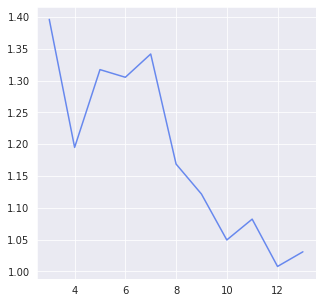

In [9]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_man)

В этом случае видим резкое падение (с k=3 До K=4), далее - подъем и несильные изменения, затем снова падение (k=7 до k=10), подъем и падение до самого минального значения в k=12.

Оптимальное количество кластеров - k=12.

Визуализируем центры:

In [12]:
centers_data = pd.DataFrame({'0': final_centers[0], '1': final_centers[1], '2': final_centers[2], 
                             '3': final_centers[3], '4': final_centers[4], '5': final_centers[5],
                             '6': final_centers[6], '7': final_centers[7], '8': final_centers[8],
                             '9': final_centers[9], '10': final_centers[10], '11': final_centers[11],
                             'index': ['X', 'Y', 'Z', 'Value']})
centers_data = centers_data.set_index('index')
centers_data = centers_data.T
centers_data['name'] = ['1 cluster',	'2 cluster',	'3 cluster', 
                        '4 cluster',	'5 cluster',	'6 cluster',
                        '7 cluster',	'8 cluster',	'9 cluster',
                        '10 cluster',	'11 cluster',	'12 cluster']
centers_data

index,X,Y,Z,Value,name
0,83.523384,96.330475,39.188994,111.076436,1 cluster
1,315.365408,139.561766,42.197169,26.657624,2 cluster
2,149.126253,39.462331,41.183777,19.065429,3 cluster
3,448.552615,137.525052,41.823911,15.208833,4 cluster
4,49.532234,36.933819,41.222203,21.048168,5 cluster
5,458.614502,32.413383,41.649918,16.654254,6 cluster
6,352.095073,35.535623,41.292756,17.652655,7 cluster
7,186.399852,134.900846,43.037681,40.198295,8 cluster
8,425.094270,87.228124,39.281147,75.921113,9 cluster
9,61.153071,143.065263,41.513069,32.497239,10 cluster


Если в предыдущем случае с евклидовым расстоянием центры кластеров были явно отдалены друг от друга, то здесь иная картина.

- Для всех пар, включающих X разделение на кластеры очевидно.
- Для пар с Y (кроме X) центры кластеров сгруппированы таким образом, что из них можно выделить 3 кластера.
- Для пар с Z(кроме X) центры кластеров сгруппированы таким образом, что из них можно выделить 3 кластера.


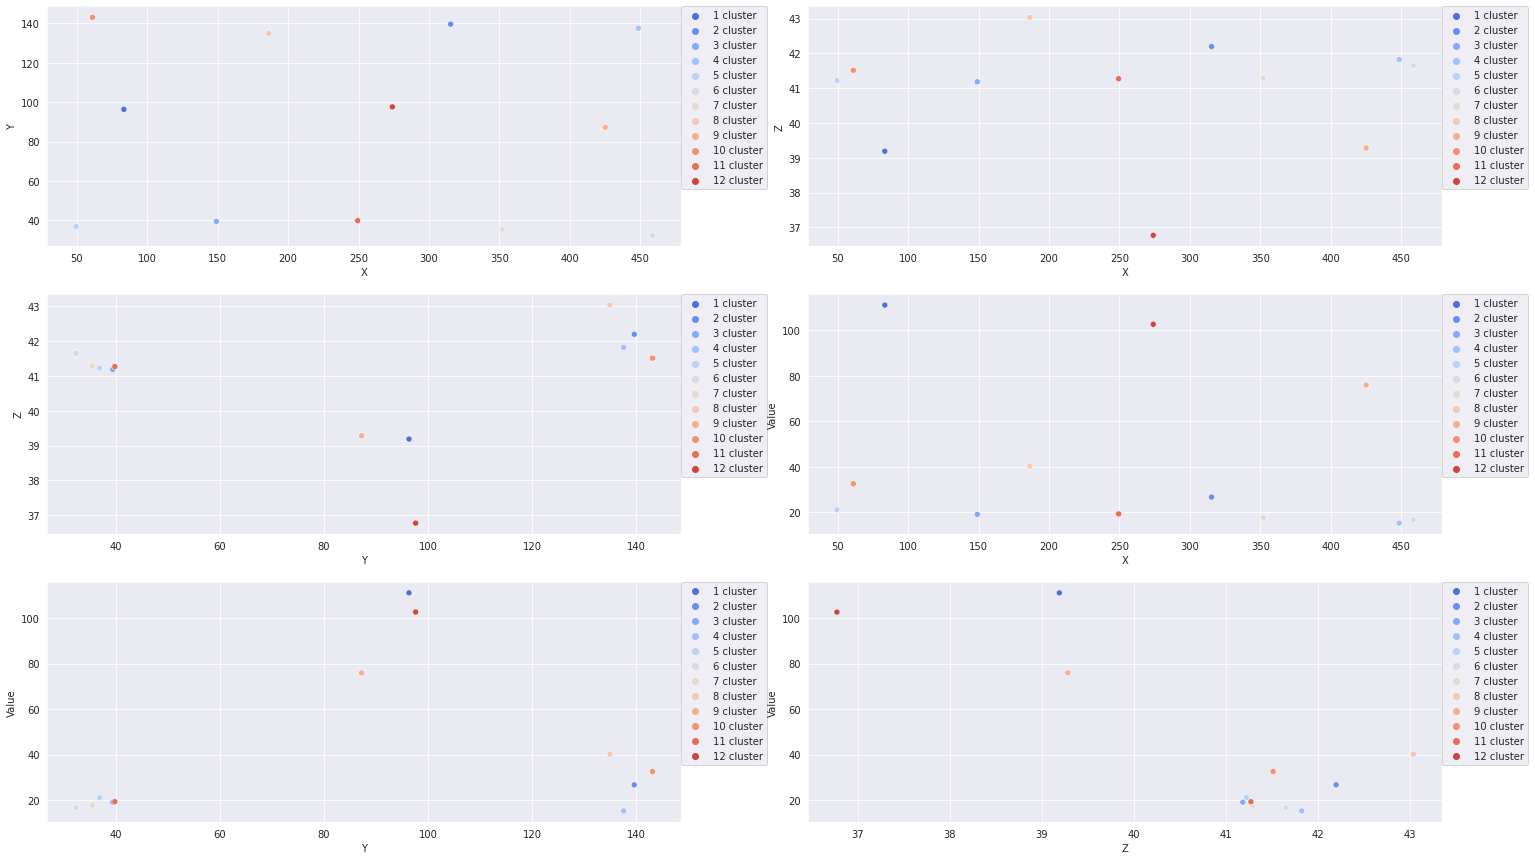

In [22]:
sns.set_palette(palette=sns.color_palette("coolwarm", 12))

f, axes = plt.subplots(3, 2, figsize=(25,15))

sns.scatterplot(centers_data.X, centers_data.Y,  hue=centers_data.name, ax=axes[0,0])
axes[0,0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.scatterplot(centers_data.X, centers_data.Z,  hue=centers_data.name, ax=axes[0,1])
axes[0,1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.scatterplot(centers_data.Y, centers_data.Z,  hue=centers_data.name, ax=axes[1,0])
axes[1,0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.scatterplot(centers_data.X, centers_data.Value,  hue=centers_data.name, ax=axes[1,1])
axes[1,1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.scatterplot(centers_data.Y, centers_data.Value,  hue=centers_data.name, ax=axes[2,0])
axes[2,0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

sns.scatterplot(centers_data.Z, centers_data.Value,  hue=centers_data.name, ax=axes[2,1])
axes[2,1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)


## Расстояние Чебышева

In [7]:
%%time
k = 13
initial_centers = kmeans_plusplus_initializer(data.to_numpy(), k).initialize()
kmeans_instance = kmeans(data.to_numpy(), initial_centers, metric=cheb_metric)

kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()
clusters_res = create_kmeans_result(clusters)
score_kemans_d = davies_bouldin_score(data, clusters_res)
print("k = ", k, " DBI = ", score_kemans_d )

k =  13  DBI =  1.0246814592174887
CPU times: user 2min 52s, sys: 11.8 s, total: 3min 4s
Wall time: 3min 3s


In [8]:
dbs_cheb = [0.9299481221958258, 1.1460494879829435, 1.1902116597585615,
            1.223688818238281, 1.1901617426610704, 1.1740387941868349,
            1.1336126854624222, 1.0644405143595508, 1.051003507234841,
            1.0128486258733187, 1.0246814592174887]

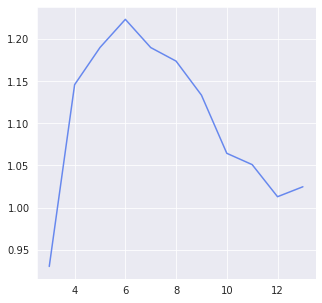

In [9]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_cheb)

Здесь, как и в случае с Евклидовым, самое маленькое значение достигается в стартовой точке (k=3). Далее следует резкий подъем и спуск до k=12, далее снова подъем.

Можно считать, что оптимальное количество кластеров k=3.

Визуализируем центры:

In [11]:
centers_data = pd.DataFrame({'0': final_centers[0], '1': final_centers[1], '2': final_centers[2], 
                             'index': ['X', 'Y', 'Z', 'Value']})
centers_data = centers_data.set_index('index')
centers_data = centers_data.T
centers_data['name'] = ['first cluster',	'second cluster',	'third cluster']
centers_data

index,X,Y,Z,Value,name
0,258.970420,133.256316,42.549471,42.309423,first cluster
1,462.732565,48.693656,40.178516,38.215945,second cluster
2,43.339718,37.498759,41.291213,21.569911,third cluster


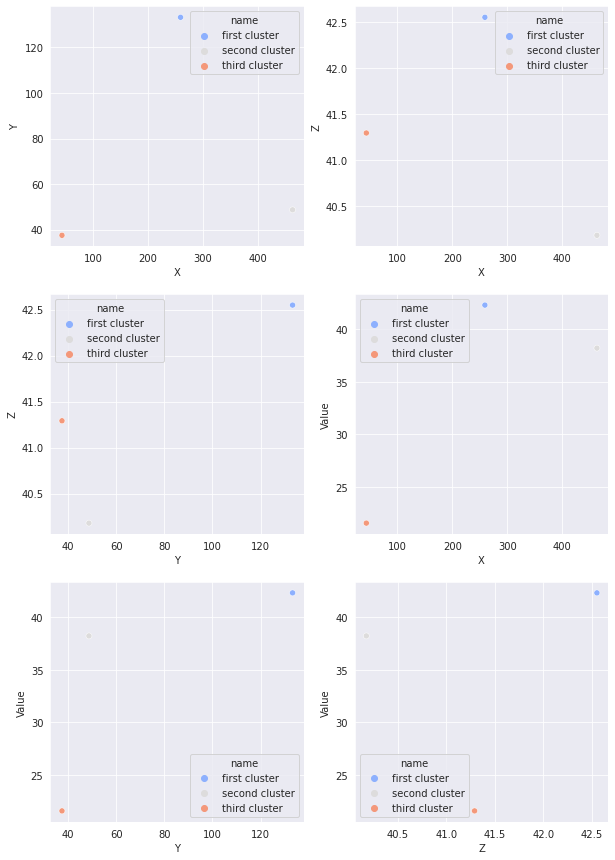

In [13]:
sns.set_palette(palette=sns.color_palette("coolwarm", 3))

f, axes = plt.subplots(3, 2, figsize=(10,15))

sns.scatterplot(centers_data.X, centers_data.Y,  hue=centers_data.name, ax=axes[0,0])
sns.scatterplot(centers_data.X, centers_data.Z,  hue=centers_data.name, ax=axes[0,1])
sns.scatterplot(centers_data.Y, centers_data.Z,  hue=centers_data.name, ax=axes[1,0])
sns.scatterplot(centers_data.X, centers_data.Value,  hue=centers_data.name, ax=axes[1,1])
sns.scatterplot(centers_data.Y, centers_data.Value,  hue=centers_data.name, ax=axes[2,0])
sns.scatterplot(centers_data.Z, centers_data.Value,  hue=centers_data.name, ax=axes[2,1])

Здесь, как и в первом случае, центры кластеров находятся далеко друг от друга.

# Soft K-means

Собственная реализация.

Включает в себя три функции на выбор для метрик: Евклида, Манхэттена и Чебышева.

Реализован расчёт индекса Дэвида-Болдина.

Также есть возможность выбора построения двумерного скаттерплота для каждой пары признаков.

In [6]:
def initialize_centers(x, num_k):
    N, D = x.shape
    centers = np.zeros((num_k, D))
    used_idx = []
    for k in range(num_k):
        idx = np.random.choice(N)
        while idx in used_idx:
            idx = np.random.choice(N)
        used_idx.append(idx)
        centers[k] = x[idx]
    return centers

def update_centers(x, r, K):
    N, D = x.shape
    centers = np.zeros((K, D))
    for k in range(K):
        centers[k] = r[:, k].dot(x) / r[:, k].sum()
    return centers

def cluster_responsibilities(centers, x, beta, method='euc'):
    N, _ = x.shape
    K, D = centers.shape
    R = np.zeros((N, K))

    if method == 'euc':
      for n in range(N):        
          R[n] = np.exp(-beta * np.linalg.norm(centers - x[n], 2, axis=1)) 
      R /= R.sum(axis=1, keepdims=True)
    
    if method == 'cheb':
      for n in range(N):        
          R[n] = np.exp(-beta * np.linalg.norm(centers - x[n], ord=np.inf, axis=1)) 
      R /= R.sum(axis=1, keepdims=True)
    
    if method == 'man':
      for n in range(N):        
          R[n] = np.exp(-beta * np.linalg.norm(centers - x[n], ord=1, axis=1)) 
      R /= R.sum(axis=1, keepdims=True)

    return R

In [7]:
def cost_func_man(x, r, centers, K):
    cost = 0
    for k in range(K):
        norm = np.linalg.norm(x - centers[k], ord=1)
        cost += (norm * np.expand_dims(r[:, k], axis=1) ).sum()
    return cost

def cost_func_cheb(x, r, centers, K):
    cost = 0
    for k in range(K):
        norm = np.linalg.norm(x - centers[k], ord=np.inf)
        cost += (norm * np.expand_dims(r[:, k], axis=1) ).max()
    return cost

def cost_func_euc(x, r, centers, K):
    cost = 0
    for k in range(K):
        norm = np.linalg.norm(x - centers[k])
        cost += (norm * np.expand_dims(r[:, k], axis=1) ).sum()
    return cost

In [8]:
def plot_soft_kmeans(x, r, k):

    random_colors = np.random.random((k, 3))
    colors = r.dot(random_colors)
    
    plt.scatter(x[:,0], x[:,3], c=colors)
    plt.title('X and Value')
    plt.show()
    plt.scatter(x[:,0], x[:,1], c=colors)
    plt.title('X and Y')
    plt.show()
    plt.scatter(x[:,0], x[:,2], c=colors)
    plt.title('X and Z')
    plt.show()
    plt.scatter(x[:,1], x[:,2], c=colors)
    plt.title('Y and Z')
    plt.show()
    plt.scatter(x[:,1], x[:,3], c=colors)
    plt.title('Y and Value')
    plt.show()
    plt.scatter(x[:,3], x[:,2], c=colors)
    plt.title('Value and Z')
    plt.show()

In [9]:
def soft_k_means(x, K, max_iters=20, beta=1., method='euc', scatter_plot='no'):
    centers = initialize_centers(x, K)
    prev_cost = 0
    for _ in range(max_iters):

        if method == 'man':
          r = cluster_responsibilities(centers, x, beta, method='man')
        if method == 'euc':
          r = cluster_responsibilities(centers, x, beta, method='euc')  
        if method == 'cheb':
          r = cluster_responsibilities(centers, x, beta, method='cheb')

        centers = update_centers(x, r, K)

        if method == 'man':
          cost = cost_func_man(x, r, centers, K)
        if method == 'euc':
          cost = cost_func_euc(x, r, centers, K)
        if method == 'cheb':
          cost = cost_func_cheb(x, r, centers, K)
          
        if np.abs(cost - prev_cost) < 1e-5:
            break
        prev_cost = cost
    if scatter_plot == 'no':
      return x, r
    if scatter_plot == 'yes':
      plot_soft_kmeans(x, r, K)
    return x, r

In [10]:
def create_soft_kmeans_result(clusters):
  result_clusters = []
  for num_cluster, cluster in enumerate(clusters):
    cluster = cluster.tolist()
    max_value = cluster.index(max(cluster))
    result_clusters.append(max_value)

  return result_clusters

## Евклидово расстояние

In [85]:
dbs_euc_soft = []

for K in range(3, 14):
  x, r = soft_k_means(data.to_numpy(), K=K, method='euc')
  clusters = create_soft_kmeans_result(r)
  dbs_euc_soft.append(davies_bouldin_score(x, clusters))
  print('for k=', K, " done.")

for k= 3  done.
for k= 4  done.
for k= 5  done.
for k= 6  done.
for k= 7  done.
for k= 8  done.
for k= 9  done.
for k= 10  done.
for k= 11  done.
for k= 12  done.
for k= 13  done.


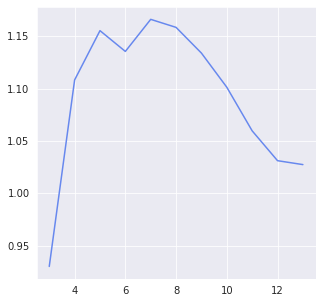

In [86]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_euc_soft)

Минимальное значение индекса при k=3, далее подъем и следующая точка спада k=12

За оптимальное количество кластеров будет принято k=3.

## Манхэттенское расстояние

In [13]:
dbs_man_soft = []

for K in range(3, 14):
  x, r = soft_k_means(data.to_numpy(), K=K, method='man')
  clusters = create_soft_kmeans_result(r)
  dbs_man_soft.append(davies_bouldin_score(x, clusters))
  print('for k=', K, " done.")

for k= 3  done.
for k= 4  done.
for k= 5  done.
for k= 6  done.
for k= 7  done.
for k= 8  done.
for k= 9  done.
for k= 10  done.
for k= 11  done.
for k= 12  done.
for k= 13  done.


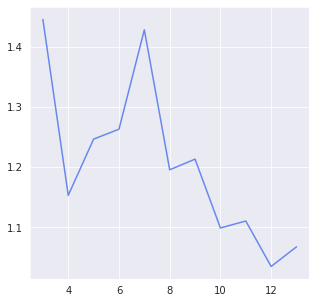

In [16]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_man_soft)

Оптимальное количество кластеров k=12.
Оптимальное количество кластеров - 3.

## Расстояние Чебышева

In [11]:
dbs_cheb_soft = []

for K in range(3, 14):
  x, r = soft_k_means(data.to_numpy(), K=K, method='cheb')
  clusters = create_soft_kmeans_result(r)
  dbs_cheb_soft.append(davies_bouldin_score(x, clusters))
  print('for k=', K, " done.")

for k= 3  done.
for k= 4  done.
for k= 5  done.
for k= 6  done.
for k= 7  done.
for k= 8  done.
for k= 9  done.
for k= 10  done.
for k= 11  done.
for k= 12  done.
for k= 13  done.


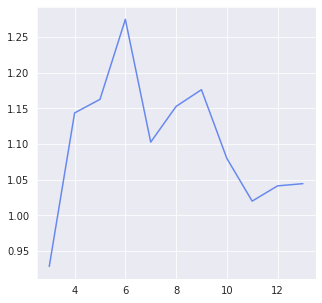

In [12]:
fig = plt.figure(figsize=(5, 5))
x = np.array([i for i in range(3, 14)])
plt.plot(x, dbs_cheb_soft)

Оптимальное количество кластеров k=3.

# **Результат работы**

- Как и k-means, так и soft k-meams в результате дали одинаковое оптимальное количество кластеров для каждого типа метрики расстояния (3, 12, 3). В среднем результаты двух алгоритмов по качеству похожи.
- Метрики играют важную в роль в геометрической кластеризации, так как за их счёт можно как значительно улучшить кластеризацию, так и значительно ухудшить её. Результат кластеризации во многом зависит от выбранной метрики.
- Лучший результат дали метрики Чебышева и Евклида. Однако в обоих случаях расстояние Чебышева было немного меньше, чем расстояние Евклида (и для k=3, и в целом). Это связано с тем, что Чебышев используется если нужно посчитать объекты как "различные" и он лучше справится, если объекты различаются в одной координате, что в нашем случае довольно часто встречается.
- Манхэттенская метрика по своему характеру отличается от Чебышева и Евклида (она четко идёт от большего к меньшему и точка k=3 является максимумом на графике, что равновисльно худшему варианту выбора кластеров). Возможно, это связано с тем, что данные довольно шумные, а манхэтенская метрика лучше работает с шумами, чем Евклидово расстояние. Скорее всего, если продолжить увеличивать число кластеров, то эта метрика покожет лучший результат. На графиках центров k-means отчётливо видно, что в некоторых координатах даже выделенные центры кластеров можно сгруппировать, вероятно, остальные метрики так и сделали, а манхэттенская смогла разделить.
- Данные имеют специфичную структуру за счёт столбца Value, так как X,Y,Z координаты и их можно сравнивать, то Value, возможно, влияет на результат кластеризации сильнее.


Таким образом, метрики в алгоритмах кластеризации играют существенную роль и во многом определеляют результат. 